In [604]:
import time
import numpy as np

from typing import Sequence, Callable
from itertools import accumulate
from matplotlib import pyplot as plt
from icecream import ic
from tqdm import tqdm

In [605]:
UNIVERSE_SIZE = 100_000
NUM_SETS = 10_000
# high density => each set is covering a lot of element     
DENSITY = 0.3

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [606]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True

# different sets has different costs (we need to minimize the total costs not the number of set taken)
COSTS = np.pow(SETS.sum(axis=1), 1.1)

def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Helper Functions

In [607]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(SETS[solution])
    return np.all(phenotype)

def plot_history(history: Sequence):
    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color="red",
    )
    _ = plt.scatter(range(len(history)), history, marker=".")

# Tweak functions

In [608]:
def single_mutation(solution: np.ndarray) -> np.ndarray:
    """Randomly drop or take one set in the universe
    Args:
        solution (np.ndarray): current solution (which sets are we taking)
    Returns:
        np.ndarray: new solution (starting solution +/- 1 set
    """
    new_sol = solution.copy()
    i = rng.integers(0, NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol

def multiple_mutation(solution: np.ndarray, probability: float = 0.01) -> np.ndarray:
    """Randomly drop or take a number of sets with a certain probability
    Args:
        solution (np.ndarray): current solution
        probability (float, optional): probability of each sets to be taken or droppped. Defaults to 0.01.
    Returns:
        np.ndarray: new solution
    """
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < probability
    if not np.any(mask):
        mask[rng.integers(NUM_SETS)] = True
    new_sol = np.logical_xor(solution, mask)
    return new_sol

# Fitness functions

In [609]:
def binary_validity_fitness(solution: np.ndarray):
    # remember that comparison is lexicografic with tupple (i.e. if a tupple is starting with 0 will be less than a valid one even
    # if the cost is less)
    return (valid(solution), -cost(solution))

def range_validity_fitness(solution: np.ndarray):
    phenotype = np.logical_or.reduce(SETS[solution])
    validity_score = UNIVERSE_SIZE - phenotype.sum()
    return (-validity_score, -cost(solution))


# Simulation Annealing

In [610]:
def sim_annealing(init_solution: np.ndarray, 
                  steps: int,
                  restarts: int,
                  tweak: Callable[[np.ndarray], tuple], 
                  fitness: Callable[[np.ndarray], tuple],
                  initial_prob: float,
                  temperature_dec_factor: float) -> tuple[list, np.ndarray]:
    
    best_solution = init_solution.copy()
    best_fitness = fitness(best_solution)
    current_solution = best_solution
    current_solution_fitness = best_fitness
    history = [ best_fitness[1] ]

    ic(fitness(best_solution))
    
    for restart in tqdm(range(restarts)):

        prob = initial_prob
        ic(current_solution_fitness)

        for step in range(steps // restarts):

            new_sol = tweak(current_solution, prob)
            f = fitness(new_sol)
            history.append(f[1])

            if f > current_solution_fitness:
                current_solution = new_sol
                current_solution_fitness = f

            prob *= temperature_dec_factor 

        if current_solution_fitness > best_fitness:
            best_fitness = current_solution_fitness
            best_solution = current_solution.copy()

        # current_solution = rng.random(NUM_SETS) < 0.1
        # current_solution_fitness = fitness(current_solution)
        

    return history, best_solution, best_fitness

## Initial solution

In [611]:
INITIAL_SOLUTION = np.full((NUM_SETS), False)
INITIAL_SOLUTION[rng.integers(NUM_SETS)] = True

ic| fitness(best_solution): (np.int64(-70140), np.float64(-83675.59008847046))
100%|██████████| 5/5 [00:03<00:00,  1.29it/s]
ic| fitness(sol): (np.int64(0), np.float64(-4874291.385897283))


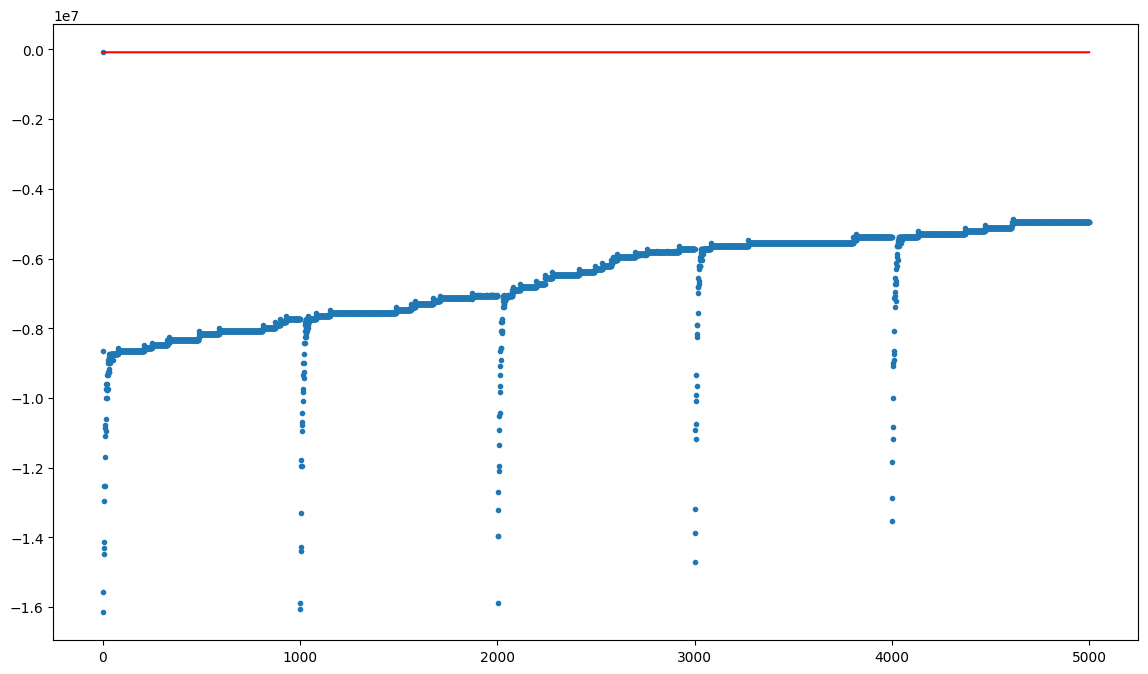

In [612]:
fitness = range_validity_fitness
tweak = multiple_mutation
his, sol, fit = sim_annealing(INITIAL_SOLUTION, 5000, 5, tweak, fitness, initial_prob=0.01, temperature_dec_factor=0.9)
ic(fitness(sol))
plot_history(his)